.. _main_calculation_immigrant:

# Main Calculation Immigration

In order to immigrate existing CRYSTAL17 calculations,
the :py:mod:`aiida_crystal17.immigration` module has been
created to take a ``.d12`` and ``.out`` file set
and replicate a ``crystal17.main`` calculation:

.. note::

    This approach may be subject to change, 
    if a general approach is developed for immigrant calculations
    (see [this ongoing issue](https://github.com/aiidateam/aiida_core/issues/1892)).


In [1]:
from aiida import load_profile
profile = load_profile()
import os
from aiida_crystal17.tests import resource_context
from aiida_crystal17.tests.utils import (
    get_or_create_local_computer, get_or_create_code, 
    get_default_metadata)
from aiida_crystal17.immigration.create_inputs import populate_builder
from aiida_crystal17.immigration.create_calcjob import immigrate_existing
from aiida_crystal17.common import display_json

from aiida.orm import Code, RemoteData
from aiida.common.folders import Folder
from aiida.tools.visualization import Graph

:py:func:`aiida_crystal17.immigration.create_inputs.populate_builder`
will create an input builder for the `crystal17.main` calculation,
from a `FolderData` node, populated with the files, and a `Code` node.

In [2]:
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.main', computer, 'mock_crystal17')

In [3]:
metadata = get_default_metadata()
metadata['options'].update({
    "input_file_name": 'INPUT',
    "output_main_file_name": "main.out"
})

with resource_context("crystal", "nio_sto3g_afm_opt") as path:
    builder = populate_builder(
        remote_data=RemoteData(
            remote_path=str(path), 
            computer=computer), 
        code=code, 
        metadata=metadata)

display_json(builder)

```json
{
  "metadata": {
    "options": {
      "resources": {
        "num_machines": 1,
        "num_mpiprocs_per_machine": 1
      },
      "max_wallclock_seconds": 1800,
      "withmpi": false,
      "input_file_name": "INPUT",
      "output_main_file_name": "main.out"
    },
    "dry_run": false
  },
  "basissets": {
    "Ni": [
      "uuid: 8037949d-6cbd-4941-b380-c7be30dd1d79 (unstored)"
    ],
    "O": [
      "uuid: c02b6eb8-56e9-4e94-8e0f-f02f41d33302 (unstored)"
    ]
  },
  "parameters": [
    "uuid: 54d33eec-3ff4-4444-9088-48edf9ee5c83 (unstored)"
  ],
  "structure": [
    "uuid: 25918928-377a-4718-bb29-db44b7e73b06 (unstored)"
  ],
  "symmetry": [
    "uuid: 9e8d3c76-845b-4aa7-8221-32491953b9e9 (unstored)"
  ],
  "kinds": [
    "uuid: de13ccd4-22f3-4700-b9e3-b5692815a8cc (unstored)"
  ],
  "code": [
    "Remote code 'crystal17.main-mock_crystal17@localhost' on localhost,",
    "pk: 1, uuid: 413a3836-4cf1-4269-9a63-52b2bde99cb4"
  ]
}
```

:py:func:`aiida_crystal17.immigration.create_calcjob.immigrate_existing`
creates a `CalcJobNode` and uses the above function,
and the `crystal17.main` parser, to create and attach incoming and outgoing nodes,
replicating a full calculation.

In [4]:
with resource_context("crystal", "nio_sto3g_afm_opt") as path:
    calc_node = immigrate_existing(
        builder, 
        remote_data=RemoteData(
            remote_path=str(path), 
            computer=computer))
calc_node

<CalcJobNode: uuid: 3a399d3e-c6fa-4ab5-b894-4580dfab94f5 (pk: 8) (aiida.calculations:crystal17.main)>

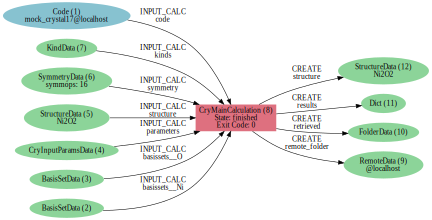

In [5]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calc_node)
graph.add_incoming(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

In [6]:
calc_node.attributes

{'sealed': True,
 'version': {'core': '1.0.0b5', 'plugin': '0.10.0b5'},
 'withmpi': False,
 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 1},
 'append_text': '',
 'exit_status': 0,
 'parser_name': 'crystal17.main',
 'prepend_text': '',
 'process_label': 'CryMainCalculation',
 'process_state': 'finished',
 'retrieve_list': ['main.out',
  'fort.34',
  'HESSOPT.DAT',
  '_scheduler-stdout.txt',
  '_scheduler-stderr.txt'],
 'remote_workdir': '/var/folders/dm/b2qnkb_n3r72slmpxlfmcjvm00lbnd/T/tmp1kqvyzb3',
 'input_file_name': 'INPUT',
 'scheduler_stderr': '_scheduler-stderr.txt',
 'scheduler_stdout': '_scheduler-stdout.txt',
 'mpirun_extra_params': [],
 'environment_variables': {},
 'max_wallclock_seconds': 1800,
 'output_main_file_name': 'main.out',
 'import_sys_environment': True,
 'retrieve_temporary_list': ['opt[ac][0-9][0-9][0-9]'],
 'custom_scheduler_commands': ''}

In [7]:
calc_node.extras

{'immigrated': True,
 '_aiida_hash': 'e9ec40cc0cfee4e578e567c4087ecc9ca8d706e46f9adeb5380ee363de1fda99',
 'immigration_func': 'aiida_crystal17.immigration.create_calcjob'}

In [8]:
display_json(calc_node.outputs.results.attributes)

```json
{
  "units": {
    "angle": "degrees",
    "energy": "eV",
    "length": "angstrom",
    "conversion": "CODATA2014"
  },
  "energy": -85125.876675219,
  "errors": [],
  "header": {
    "crystal_version": 17,
    "crystal_subversion": "1.0.1"
  },
  "volume": 42.49241208568,
  "warnings": [
    "WARNING **** INT_SCREEN **** CELL PARAMETERS OPTIMIZATION ONLY"
  ],
  "calculation": {
    "n_ao": 46,
    "spin": true,
    "type": "unrestricted open shell",
    "n_atoms": 4,
    "n_shells": 14,
    "n_symops": 16,
    "n_core_el": 40,
    "n_electrons": 72,
    "n_kpoints_ibz": 75,
    "n_kpoints_gilat": 75
  },
  "energy_units": "eV",
  "parser_class": "CryMainParser",
  "parser_errors": [],
  "mulliken_spins": [
    3.234,
    -3.234,
    -0.172,
    0.172
  ],
  "opt_iterations": 19,
  "parser_version": "0.10.0b5",
  "scf_iterations": 16,
  "number_of_atoms": 4,
  "parser_warnings": [],
  "mulliken_charges": [
    0.363,
    0.363,
    -0.363,
    -0.363
  ],
  "parser_exceptions": [],
  "mulliken_electrons": [
    27.637,
    27.637,
    8.363,
    8.363
  ],
  "mulliken_spin_total": 0.0,
  "number_of_assymetric": 4,
  "execution_time_seconds": 3018
}
```